In [2]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

ModuleNotFoundError: No module named 'pytorch3d'

In [2]:
device = torch.device("cuda:")
torch.cuda.set_device(device)

# Set paths
DATA_DIR = "./data"
model_dir = "/hdd/zen/data/Reallite/ShapeNetCore.v2/02958343/7cb387de84bfd2f5fcf949f5ffa7ff6/models/model_normalized.obj"
# model_dir = "/hdd/zen/data/Reallite/ShapeNetCore.v1/02958343/7ee2193b072afa652935bed12a852dcf/model.obj"
obj_filename = model_dir

# Load obj file
mesh = load_objs_as_meshes([obj_filename], load_textures = True, device=device)

texture_image=mesh.textures.maps_padded()

In [3]:

# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)
# texture_image=mesh.textures.maps_padded()

In [4]:
mesh.textures._faces_uvs_padded.shape

AttributeError: 'NoneType' object has no attribute '_faces_uvs_padded'

In [5]:
plt.figure(figsize=(7,7))
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.grid("off");
plt.axis('off');

NameError: name 'texture_image' is not defined

<Figure size 504x504 with 0 Axes>

In [6]:
# Initialize an OpenGL perspective camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.7, 0, 180) 
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to rasterize_meshes.py for explanations of these parameters. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    bin_size=0
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

In [7]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off")

ValueError: Expected meshes.textures to be an instance of Textures; got <class 'NoneType'>

In [11]:
lights.location = torch.tensor([0.0, 0.0, +1.0], device=device)[None]
images = renderer(mesh, lights=lights)

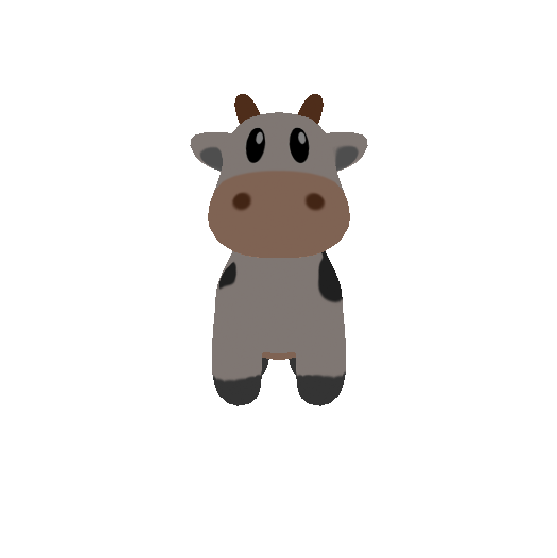

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

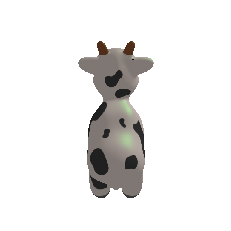

In [29]:
R, T = look_at_view_transform(dist=2.7, elev=45, azim=0)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# Move the light location so the light is shining on the cow's face.  
lights.location = torch.tensor([[2.0, 2.0, -2.0]], device=device)

# Change specular color to green and change material shininess 
materials = Materials(
    device=device,
    specular_color=[[0.0, 1.0, 0.0]],
    shininess=10.0
)

# Re render the mesh, passing in keyword arguments for the modified components.
images = renderer(mesh, lights=lights, materials=materials, cameras=cameras)
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");